In [2]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from data_generation.data_generator_main import run_data_simulations
from data_generation.data_simulator import IndividualDataSimulator
from data_generation.network_generator import GraphGenerator, NetworkFeatureExtractor
from constants import NetworkSettings, DataGenerationSettings
from methods.methods_est import LinearRegressionEstimator
from methods.visualization import ResultsPlotter, plot_result_graphs, plot_fpr_by_method, plot_bias_with_corruption_overlay
from data_generation.data_simulator import IndividualDataSimulator
from methods.methods_est import PropensityScoreMatcher

/Users/polinarevina/Library/Caches/pypoetry/virtualenvs/simulations-notebooks-2NAxyaa6-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/polinarevina/Library/Caches/pypoetry/virtualenvs/simulations-notebooks-2NAxyaa6-py3.12/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function array> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [34]:
all_results = pd.read_csv("./data_results/01_01_all_results_.csv")
corrupt_df = pd.read_csv("./data_results/02_01_corrupt_df_.csv")

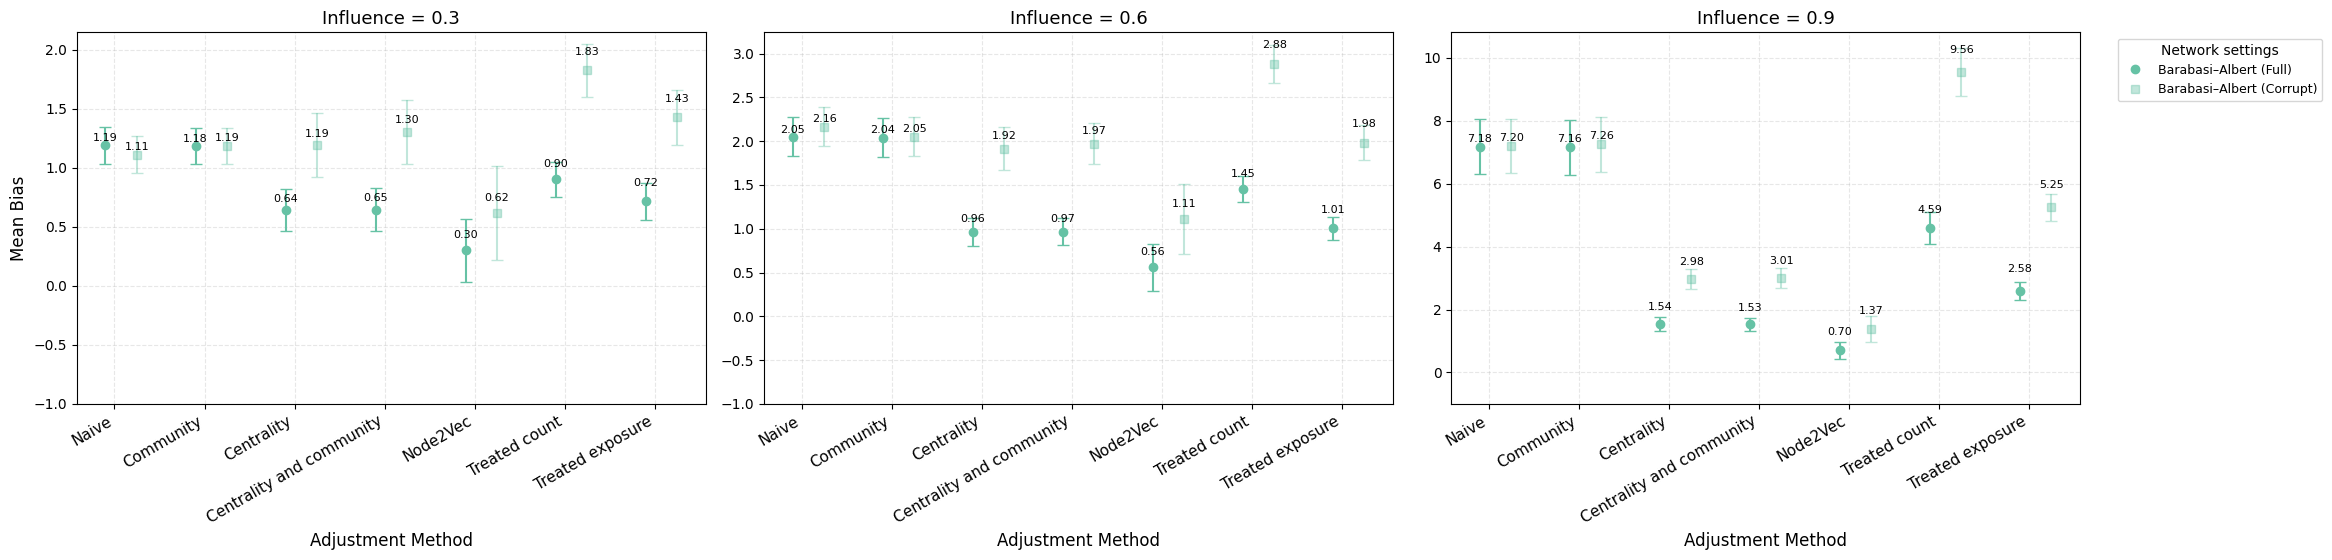

In [89]:
plot_bias_full_corruption(
    df_full=all_results[all_results["Network"] == "barabasi_albert_graph"],
    df_corrupt=corrupt_df[corrupt_df["Network"] == "barabasi_albert_graph"],
    method_order=METHOD_LABELS.keys(),
    network_colors=COLORS,
    setting_styles=CORRUPT_SETTINGS_STYLE,
    method_labels=METHOD_LABELS
)

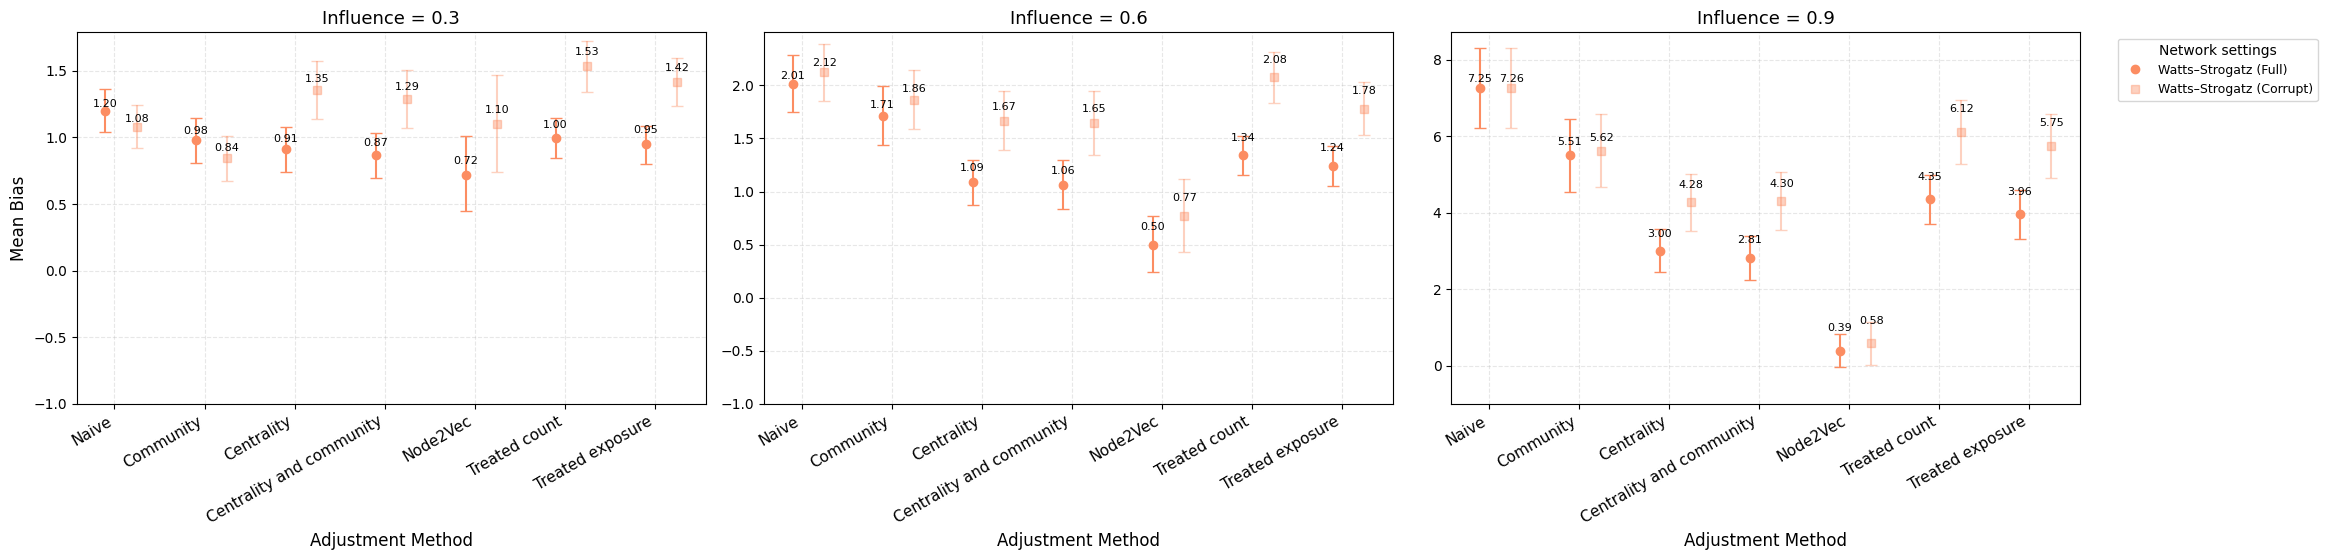

In [90]:
plot_bias_full_corruption(
    df_full=all_results[all_results["Network"] == "watts_strogatz_graph"],
    df_corrupt=corrupt_df[corrupt_df["Network"] == "watts_strogatz_graph"],
    method_order=METHOD_LABELS.keys(),
    network_colors=COLORS,
    setting_styles=CORRUPT_SETTINGS_STYLE,
    method_labels=METHOD_LABELS
)

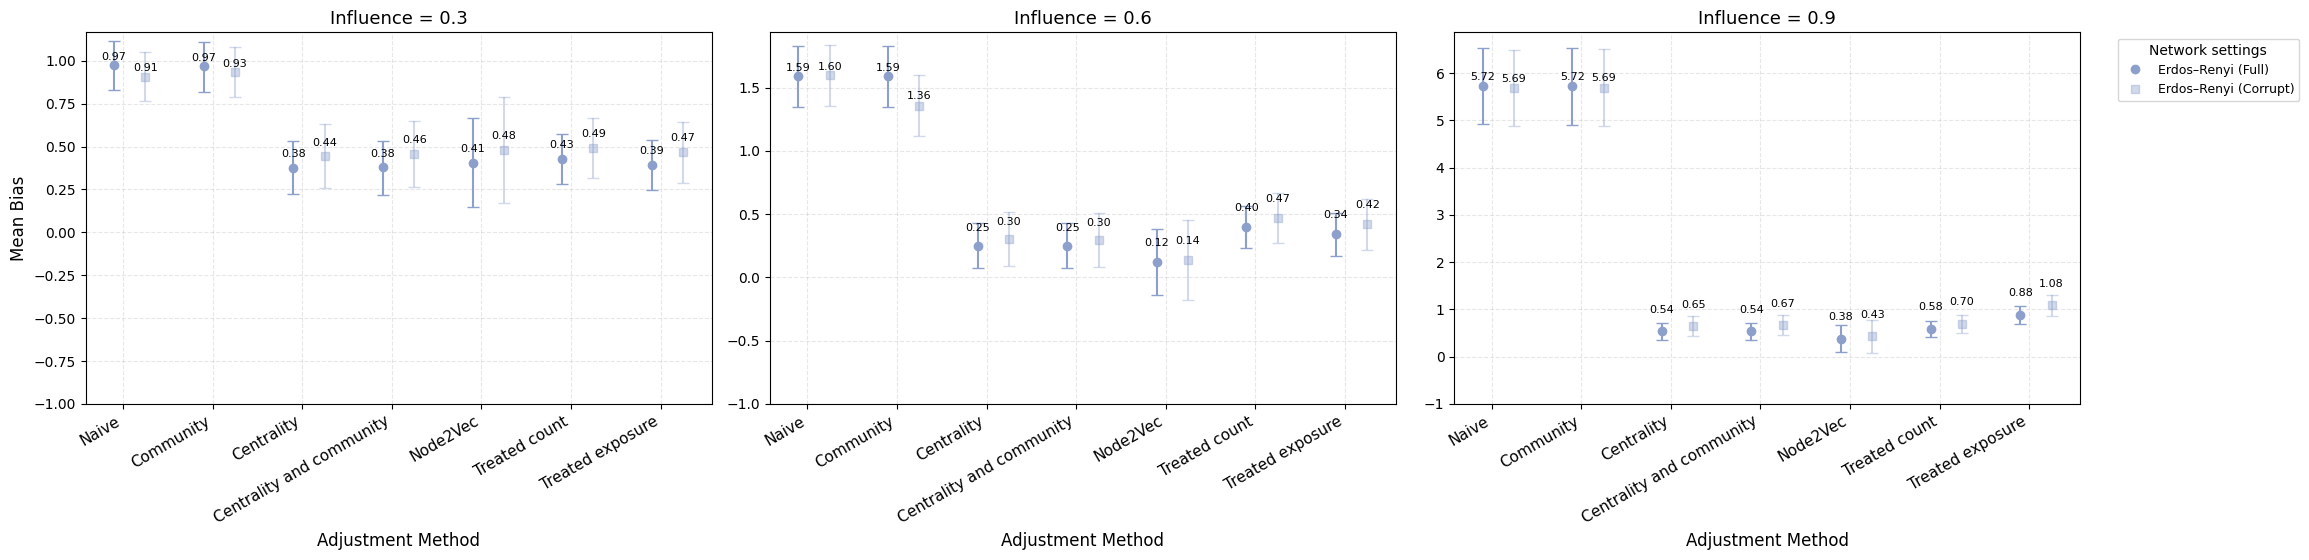

In [91]:
plot_bias_full_corruption(
    df_full=all_results[all_results["Network"] == "erdos_renyi_graph"],
    df_corrupt=corrupt_df[corrupt_df["Network"] == "erdos_renyi_graph"],
    method_order=METHOD_LABELS.keys(),
    network_colors=COLORS,
    setting_styles=CORRUPT_SETTINGS_STYLE,
    method_labels=METHOD_LABELS
)